In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = 'https://raw.githubusercontent.com/ackben0226/Price-Strategy-Using-A-B-Testing/main/Retail%20Sales%20Data.csv'
#data = pd.read_csv(r'/content/Retail Sales Data.csv')
data = pd.read_csv(url)
data.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-05-15,CUST068,Female,61,Beauty,3,50,150
1,2,2023-06-19,CUST007,Female,28,Beauty,4,50,200
2,3,2023-09-10,CUST097,Female,38,Home,5,300,1500
3,4,2023-07-02,CUST100,Female,63,Beauty,1,50,50
4,5,2023-03-06,CUST012,Female,62,Sports,3,200,600


In [104]:
data['Date'] = pd.to_datetime(data['Date'])

In [105]:
data['Product Category'].value_counts()

Product Category
Electronics    184
Sports         180
Home           176
Clothing       164
Books          163
Beauty         133
Name: count, dtype: int64

In [106]:
print('Data Information', data.info())
print('-'*45 + '\n')
print('Data Description', data.describe())
print('-'*70 + '\n')
print('Descriptive statistics', data.describe(include = 'object'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    1000 non-null   int64         
 1   Date              1000 non-null   datetime64[ns]
 2   Customer ID       1000 non-null   object        
 3   Gender            1000 non-null   object        
 4   Age               1000 non-null   int64         
 5   Product Category  1000 non-null   object        
 6   Quantity          1000 non-null   int64         
 7   Price per Unit    1000 non-null   int64         
 8   Total Amount      1000 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 70.4+ KB
Data Information None
---------------------------------------------

Data Description        Transaction ID                        Date          Age     Quantity  \
count     1000.000000                        1000  1000.000000  10

### __Create A/B Testing Groups__
- ### **Discount Strategy:** Test if giving discounts (e.g., 10% off) increases sales.

Sports Discount Results:
        Test Group  Avg_Revenue  Total_Revenue  Sample_Size
0  A (No Discount)   586.046512        50400.0           86
1     B (Discount)   530.425532        49860.0           94
P-value: 0.0239
------------------------------------------------------------

Beauty Discount Results:
        Test Group  Avg_Revenue  Total_Revenue  Sample_Size
0  A (No Discount)   148.214286         8300.0           56
1     B (Discount)   145.519481        11205.0           77
P-value: 0.3506
------------------------------------------------------------

Clothing Discount Results:
        Test Group  Avg_Revenue  Total_Revenue  Sample_Size
0  A (No Discount)  1597.402597       123000.0           77
1     B (Discount)  1396.551724       121500.0           87
P-value: 0.0079
------------------------------------------------------------

Electronics Discount Results:
        Test Group  Avg_Revenue  Total_Revenue  Sample_Size
0  A (No Discount)  2955.056180       263000.0           89

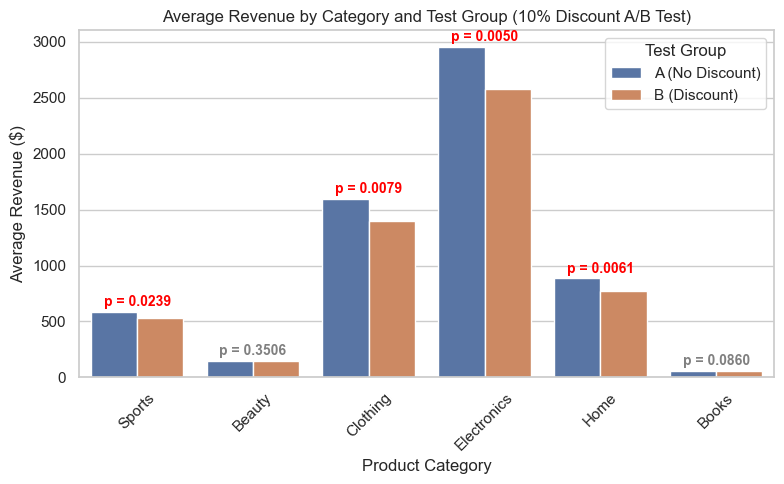

In [109]:
from scipy import stats

def test_discount_strategy(data, category, discount=0.1):
    # Filter by category
    
    cat_data = data[data["Product Category"] == category].copy()

    # Split into A/B groups
    np.random.seed(42)
    cat_data["Test Group"] = np.random.choice(["A (No Discount)", "B (Discount)"], 
                                              size=len(cat_data))

    # Apply discount to Group B
    cat_data["Adjusted Price"] = np.where(
        cat_data["Test Group"] == "B (Discount)",
        cat_data["Price per Unit"] * (1 - discount),
        cat_data["Price per Unit"]
    )
    cat_data["Adjusted Revenue"] = cat_data["Quantity"] * cat_data["Adjusted Price"]

    # Compare groups
    grouped = cat_data.groupby("Test Group").agg(
        Avg_Revenue=("Adjusted Revenue", "mean"),
        Total_Revenue=("Adjusted Revenue", "sum"),
        Sample_Size=("Test Group", "count")
    ).reset_index()

    # T-test
    t_stat, p_value = stats.mannwhitneyu(
        cat_data[cat_data["Test Group"] == "A (No Discount)"]["Adjusted Revenue"],
        cat_data[cat_data["Test Group"] == "B (Discount)"]["Adjusted Revenue"]
    )

    return grouped, p_value

# List of categories to test
categories_to_test = ["Sports", "Beauty", "Clothing", 'Electronics', 'Home', 'Books']

# Loop through each category
for category in categories_to_test:
    results, p_value = test_discount_strategy(data, category)

    # Print formatted results
    print(f"{category} Discount Results:")
    print(results)
    print(f"P-value: {p_value:.4f}")
    print("-" * 60 + "\n")

all_results_list = []

for category in categories_to_test:
    results, p_value = test_discount_strategy(data, category)

    # Add category & p_value columns to results for later plotting
    results["Category"] = category
    results["P-value"] = p_value

    all_results_list.append(results)

# Combine all category results into one dataframe
all_results = pd.concat(all_results_list, ignore_index=True)

# Now plot using all_results as before
plt.figure(figsize=(8, 5))
sns.barplot(data=all_results, x="Category", y="Avg_Revenue", hue="Test Group", palette=["#4c72b0", "#dd8452"])

# Annotate p-values on the plot
for cat in categories_to_test:
    p_val = all_results[all_results["Category"] == cat]["P-value"].values[0]
    max_val = all_results[all_results["Category"] == cat]["Avg_Revenue"].max()
    color = "red" if p_val < 0.05 else "gray"
    plt.text(
        x=categories_to_test.index(cat),
        y=max_val + 50,
        s=f"p = {p_val:.4f}",
        ha="center",
        fontsize=10,
        color=color,
        fontweight="bold"
    )

plt.title("Average Revenue by Category and Test Group (10% Discount A/B Test)")
plt.ylabel("Average Revenue ($)")
plt.xlabel("Product Category")
plt.xticks(rotation=45)
plt.legend(title="Test Group")
plt.tight_layout()
plt.show()

 ### **Discount Strategy:** Test if giving discounts (e.g., 10% off) increases sales Using Customers.
 #### Customer-Level Group Assignment

In [63]:
def test_discount_strategy(data, category, discount=0.1):
    # Filter customers who bought the category
    customers = data[data["Product Category"] == category]["Customer ID"].unique()
    
    # Assign customers to groups
    np.random.seed(42)
    customer_groups = pd.DataFrame({
        "Customer ID": customers,
        "Test Group": np.random.choice(["A (No Discount)", "B (Discount)"], size=len(customers))
    })
    
    # Merge group assignments with transaction data
    cat_data = pd.merge(data, customer_groups, on="Customer ID", how="inner")

    # Apply discount for Group B
    cat_data["Adjusted Sales"] = cat_data.apply(
        lambda row: row["Total Amount"] * (1 - discount) if row["Test Group"] == "B (Discount)" else row["Total Amount"],
        axis=1
    )

    # Group by test group and calculate average sales
    grouped = cat_data.groupby("Test Group")["Adjusted Sales"].mean().reset_index()

    # Perform an independent t-test between groups
    sales_A = cat_data[cat_data["Test Group"] == "A (No Discount)"]["Adjusted Sales"]
    sales_B = cat_data[cat_data["Test Group"] == "B (Discount)"]["Adjusted Sales"]
    t_stat, p_value = stats.mannwhitneyu(sales_A, sales_B, alternative='two-sided')

    return grouped, p_value

Category: Sports
        Test Group  Adjusted Sales
0  A (No Discount)     1041.529126
1     B (Discount)      987.576923
p-value: 0.4696214273475261
----------------------------------------
Category: Beauty
        Test Group  Adjusted Sales
0  A (No Discount)     1098.764045
1     B (Discount)      891.161194
p-value: 0.014381371681110571
----------------------------------------
Category: Clothing
        Test Group  Adjusted Sales
0  A (No Discount)     1040.095465
1     B (Discount)     1021.530474
p-value: 0.6910880237558659
----------------------------------------
Category: Electronics
        Test Group  Adjusted Sales
0  A (No Discount)     1179.074492
1     B (Discount)      960.529412
p-value: 0.012032855523157979
----------------------------------------
Category: Home
        Test Group  Adjusted Sales
0  A (No Discount)     1085.616114
1     B (Discount)      975.091463
p-value: 0.3332473237522464
----------------------------------------
Category: Books
        Test Group  

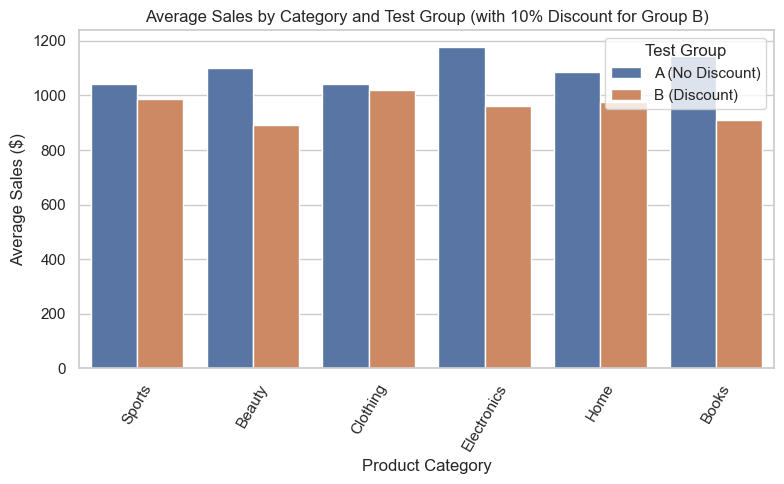

In [64]:
# List of categories to test
categories_to_test = ["Sports", "Beauty", "Clothing", 'Electronics', 'Home', 'Books']

for category in categories_to_test:
    grouped_results, p_value = test_discount_strategy(data, category=category, discount=0.1)

    print(f"Category: {category}")
    print(grouped_results)
    print("p-value:", p_value)
    print("-" * 40)

# To store results
results = []

for category in categories_to_test:
    grouped_results, p_value = test_discount_strategy(data, category=category, discount=0.1)
    for _, row in grouped_results.iterrows():
        results.append({
            "Category": category,
            "Test Group": row["Test Group"],
            "Average Sales": row["Adjusted Sales"]
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot using seaborn
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Category", y="Average Sales", hue="Test Group")

plt.title("Average Sales by Category and Test Group (with 10% Discount for Group B)")
plt.ylabel("Average Sales ($)")
plt.xlabel("Product Category")
plt.xticks(rotation=60)
plt.legend(title="Test Group")
plt.tight_layout()
plt.show()

### Incorporate Profitability Analysis

In [65]:
import pandas as pd
import numpy as np
from scipy import stats

# Assign cost based on margin
def assign_realistic_costs(data, cost_margin=0.3):
    data = data.copy()
    data["Cost per Unit"] = data["Price per Unit"] * cost_margin
    return data

# A/B testing simulation
def test_discount_strategy(data, category, discount=0.1):
    # Ensure costs are calculated first
    data = assign_realistic_costs(data)

    # Filter customers who bought the selected category
    customers = data[data["Product Category"] == category]["Customer ID"].unique()
    
    # Randomly assign test groups
    np.random.seed(42)
    customer_groups = pd.DataFrame({
        "Customer ID": customers,
        "Test Group": np.random.choice(["A (No Discount)", "B (Discount)"], size=len(customers))
    })
    
    # Merge group assignment with main data
    cat_data = pd.merge(data, customer_groups, on="Customer ID", how="inner")
    
    # Apply discount logic
    cat_data["Adjusted Unit Price"] = cat_data.apply(
        lambda row: row["Price per Unit"] * (1 - discount) if row["Test Group"] == "B (Discount)" else row["Price per Unit"],
        axis=1
    )

    # Calculate adjusted revenue and profit
    cat_data["Adjusted Revenue"] = cat_data["Adjusted Unit Price"] * cat_data["Quantity"]
    cat_data["Adjusted Profit"] = (cat_data["Adjusted Unit Price"] - cat_data["Cost per Unit"]) * cat_data["Quantity"]

    # Aggregate results
    grouped = cat_data.groupby("Test Group").agg(
        Total_Profit=("Adjusted Profit", "sum"),
        Total_Revenue=("Adjusted Revenue", "sum"),
        Average_Profit_Per_Customer=("Adjusted Profit", "mean")
    ).reset_index()

    # T-test for profit difference
    profit_A = cat_data[cat_data["Test Group"] == "A (No Discount)"]["Adjusted Profit"]
    profit_B = cat_data[cat_data["Test Group"] == "B (Discount)"]["Adjusted Profit"]
    t_stat, p_value = stats.mannwhitneyu(profit_A, profit_B, alternative='two-sided')

    return grouped, p_value

In [66]:
# List of categories to test
categories_to_test = ["Sports", "Beauty", "Clothing", 'Electronics', 'Home', 'Books']

for category in categories_to_test:
    grouped_results, p_value = test_discount_strategy(data, category=category, discount=0.1)
    data = assign_realistic_costs(data)

    print(f"Category: {category}")
    print(grouped_results)
    print("p-value:", p_value)
    print("-" * 76)

Category: Sports
        Test Group  Total_Profit  Total_Revenue  Average_Profit_Per_Customer
0  A (No Discount)      300377.0       429110.0                   729.070388
1     B (Discount)      291006.0       436509.0                   658.384615
p-value: 0.34039305914669316
----------------------------------------------------------------------------
Category: Beauty
        Test Group  Total_Profit  Total_Revenue  Average_Profit_Per_Customer
0  A (No Discount)      273812.0       391160.0                   769.134831
1     B (Discount)      199026.0       298539.0                   594.107463
p-value: 0.010060980511896644
----------------------------------------------------------------------------
Category: Clothing
        Test Group  Total_Profit  Total_Revenue  Average_Profit_Per_Customer
0  A (No Discount)      305060.0       435800.0                   728.066826
1     B (Discount)      301692.0       452538.0                   681.020316
p-value: 0.5503678093400994
-------------

In [69]:
results_df

,Category,Test Group,Average Sales
0,Sports,A (No Discount),1041.529126
1,Sports,B (Discount),987.576923
2,Beauty,A (No Discount),1098.764045
3,Beauty,B (Discount),891.161194
4,Clothing,A (No Discount),1040.095465
5,Clothing,B (Discount),1021.530474
6,Electronics,A (No Discount),1179.074492
7,Electronics,B (Discount),960.529412
8,Home,A (No Discount),1085.616114
9,Home,B (Discount),975.091463


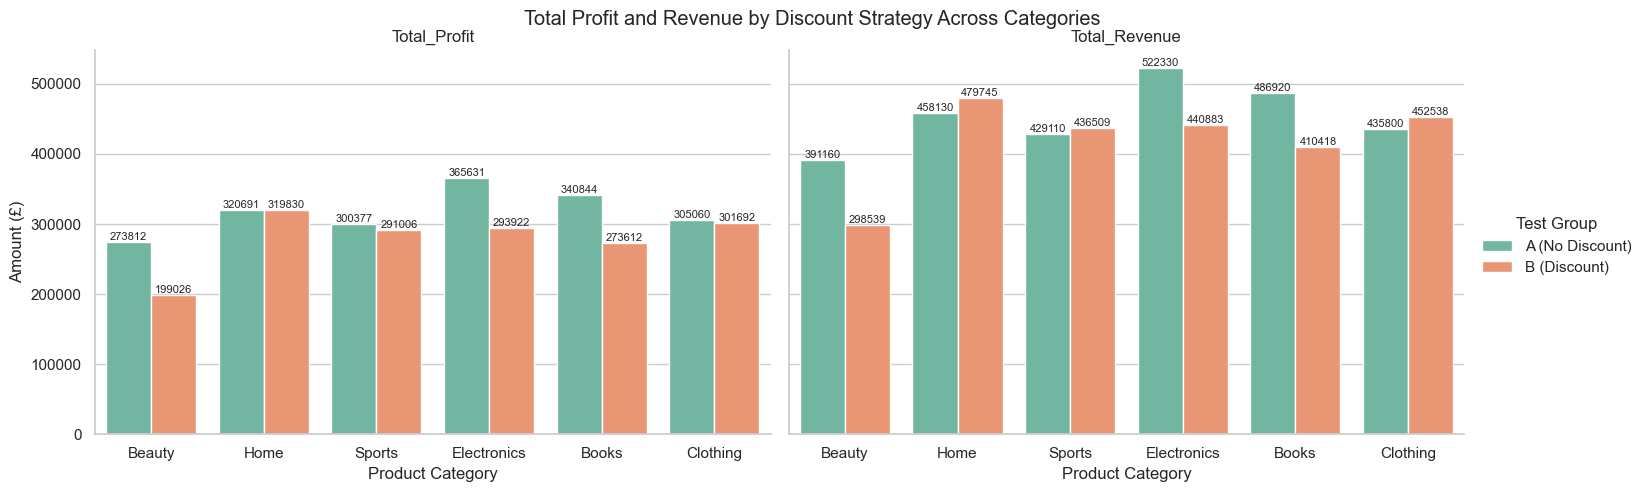

In [74]:
all_results = []

for category in data["Product Category"].unique():
    grouped, p_value = test_discount_strategy(data,category)
    grouped['Category'] = category
    all_results.append(grouped)

results_df = pd.concat(all_results, ignore_index = True)
    
# Reshape for seaborn
melted_df = results_df.melt(
    id_vars=["Test Group", "Category"],
    value_vars=["Total_Profit", "Total_Revenue"],
    var_name="Metric",
    value_name="Amount"
)

# Set Seaborn theme
sns.set(style="whitegrid")

# Create Faceted Bar Plots
g = sns.catplot(
    data=melted_df, kind="bar",
    x="Category", y="Amount", hue="Test Group",
    col="Metric", palette="Set2", errorbar=None,
    height=5, aspect=1.5
)

# Customize Titles and Labels
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Total Profit and Revenue by Discount Strategy Across Categories")
g.set_titles("{col_name}")
g.set_axis_labels("Product Category", "Amount (£)")

# Add bar labels
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f", label_type="edge", fontsize=8)

plt.show()


In [72]:
results_df

,Test Group,Total_Profit,Total_Revenue,Average_Profit_Per_Customer,Category
0,A (No Discount),273812.0,391160.0,769.134831,Beauty
1,B (Discount),199026.0,298539.0,594.107463,Beauty
2,A (No Discount),320691.0,458130.0,759.931280,Home
3,B (Discount),319830.0,479745.0,650.060976,Home
4,A (No Discount),300377.0,429110.0,729.070388,Sports
5,B (Discount),291006.0,436509.0,658.384615,Sports
6,A (No Discount),365631.0,522330.0,825.352144,Electronics
7,B (Discount),293922.0,440883.0,640.352941,Electronics
8,A (No Discount),340844.0,486920.0,800.103286,Books
9,B (Discount),273612.0,410418.0,606.678492,Books


### Profit and Revenue Comparison

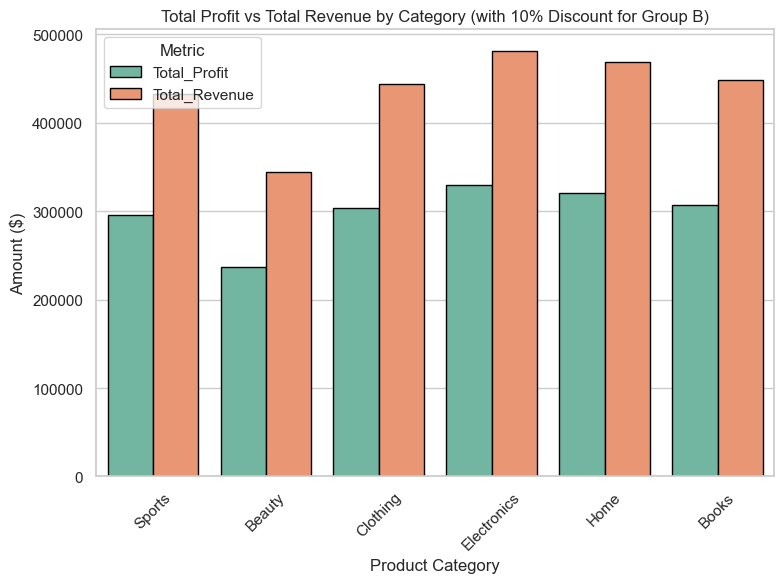

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# List of categories to test
categories_to_test = ["Sports", "Beauty", "Clothing", "Electronics", "Home", "Books"]

# To store all category results
all_results = []

for category in categories_to_test:
    grouped_results, p_value = test_discount_strategy(data, category=category, discount=0.1)
    grouped_results["Category"] = category
    grouped_results["p_value"] = p_value
    all_results.append(grouped_results)

# Combine all category results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)

# Melt the dataframe for easier plotting
plot_data = final_results_df.melt(
    id_vars=["Category", "Test Group", "p_value"], 
    value_vars=["Total_Profit", "Total_Revenue"], 
    var_name="Metric", 
    value_name="Amount"
)

# Set up the grouped barplot
plt.figure(figsize=(8, 6))
sns.barplot(data=plot_data, x="Category", y="Amount", hue="Metric", errorbar=None, palette="Set2", 
            dodge=True, edgecolor="black")

# Add titles and labels
plt.title("Total Profit vs Total Revenue by Category (with 10% Discount for Group B)")
plt.ylabel("Amount ($)")
plt.xlabel("Product Category")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()

plt.show()

## Test for Check for Quantity Drop:
### __Price Increase Sensitivity:__ Test if increasing the price (eg. 10%) affects revenue and purchase behavior (customers sensitivity to price increase)__ 


Business Results:
                Test Group  Customers  Transactions  Avg_Quantity   Avg_Price  \
0      A (Original Price)         97           482      2.981328  392.448133   
1  B (10% Price Increase)         99           487      2.987680  369.805544   

   Avg_Revenue  Total_Revenue  Revenue_Lift  
0  1142.904564       550880.0      0.000000  
1  1119.522177       545207.3     -0.010298  

Statistical Significance:
p_value = 0.773791822175178




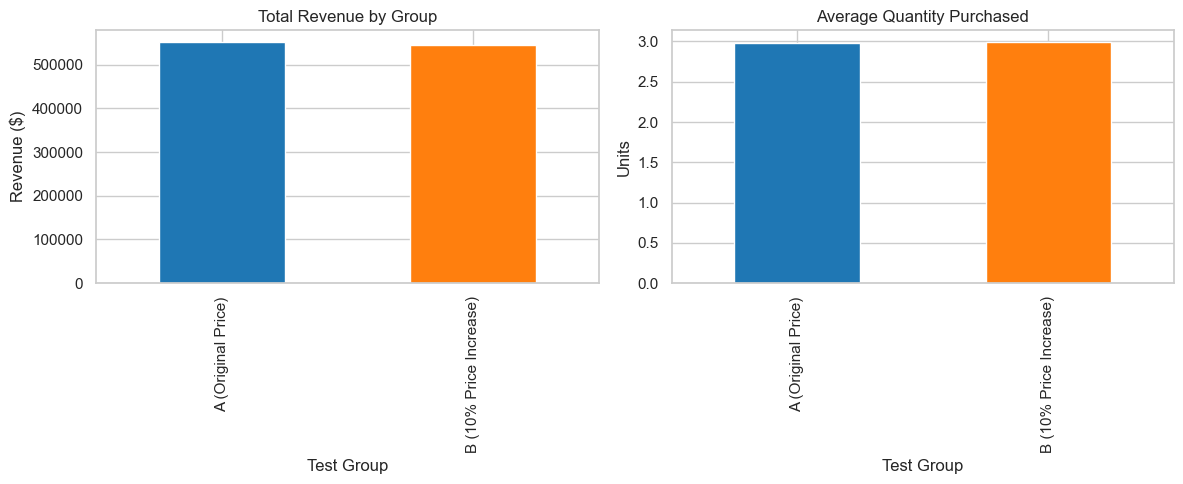

In [89]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

def analyze_price_impact(data, price_increase=0.10, random_seed=42):
    """
    Analyzes the impact of price increases on customer purchasing behavior.
    
    Parameters:
    - data: DataFrame containing transaction data (must include 'Price per Unit' and 'Quantity')
    - price_increase_pct: Percentage increase to test (default 10%)
    - random_seed: Random seed for reproducibility
    
    Returns:
    - Tuple of (results DataFrame, statistical test results, visualization figure)
    """
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # 1. Experimental Setup
    data["Test Group"] = np.random.choice(
        ["A (Original Price)", "B (10% Price Increase)"], 
        size=len(data),
        #p=[0.5, 0.5]  # Equal split for A/B test
    )
    
    # 2. Apply Price Adjustment
    data["Adjusted Price"] = np.where(
        data["Test Group"] == "B (10% Price Increase)",
        data["Price per Unit"] * (1 + price_increase),
        data["Price per Unit"]
    )
    
    # 3. Calculate Metrics
    data["Adjusted Revenue"] = data["Quantity"] * data["Adjusted Price"]
    
    # 4. Aggregate Results
    grouped = data.groupby("Test Group").agg(
        Customers=("Customer ID", "nunique"),
        Transactions=("Transaction ID", "count"),
        Avg_Quantity=("Quantity", "mean"),
        Avg_Price=("Adjusted Price", "mean"),
        Avg_Revenue=("Adjusted Revenue", "mean"),
        Total_Revenue=("Adjusted Revenue", "sum"),
        Revenue_Lift=("Adjusted Revenue", lambda x: x.sum()/data[data["Test Group"]=="A (Original Price)"]["Adjusted Revenue"].sum() - 1)
    ).reset_index()
    
    # 5. Statistical Testing
    # Mann-Whitney for revenue comparison (non-parametric)
    u_stat, p_value = stats.mannwhitneyu(
        data[data["Test Group"] == "A (Original Price)"]["Adjusted Revenue"],
        data[data["Test Group"] == "B (10% Price Increase)"]["Adjusted Revenue"],
        alternative='two-sided'
    )
    
    # 6. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Revenue Comparison
    grouped.set_index("Test Group")["Total_Revenue"].plot(
        kind="bar", 
        ax=ax1,
        title="Total Revenue by Group",
        ylabel="Revenue ($)",
        color=["#1f77b4", "#ff7f0e"]
    )
    
    # Quantity Comparison
    grouped.set_index("Test Group")["Avg_Quantity"].plot(
        kind="bar",
        ax=ax2,
        title="Average Quantity Purchased",
        ylabel="Units",
        color=["#1f77b4", "#ff7f0e"]
    )
    
    plt.tight_layout()
    
    return grouped, p_value, fig


results, stats_results, viz = analyze_price_impact(data, price_increase=0.10)
print("\nBusiness Results:\n", results)
print("\nStatistical Significance:\np_value =", stats_results)
print('\n')
plt.show()

## Test for Check for Quantity Drop:
### __If the price increase caused a significant drop in quantity, customers are price sensitive.__ 

- ### __Bundling Strategy:__ Test if selling products in bundles increases total revenue.

In [81]:
avg_unit_price = data.groupby('Product Category')['Price per Unit'].mean()
avg_unit_price = avg_unit_price[avg_unit_price.index != 'Bundle']
avg_unit_price

Product Category
Beauty           50.0
Books            20.0
Clothing        500.0
Electronics    1000.0
Home            300.0
Sports          200.0
Name: Price per Unit, dtype: float64

In [82]:
import pandas as pd
import numpy as np
from scipy import stats
from itertools import combinations

# Function to determine bundle prices
def determine_bundle_prices(discount=0.15):
    
    # Average prices per category
    avg_unit_price = data.groupby('Product Category')['Price per Unit'].mean()
    prices = avg_unit_price[avg_unit_price.index != 'Bundle']

    # Generate all unique category pairs
    category_pairs = list(combinations(prices.keys(), 2))

    # Calculate bundle prices
    bundle_prices = {}
    for cat1, cat2 in category_pairs:
        individual_total = prices[cat1] + prices[cat2]
        bundle_price = round(individual_total * (1 - discount), 2)
        bundle_prices[(cat1, cat2)] = (round(individual_total, 2), bundle_price)

    return bundle_prices

# Identify eligible customers (last 30 days from latest date)
data["Date"] = pd.to_datetime(data["Date"])
latest_date = data["Date"].max()
eligible_customers = data[
    data["Date"] >= (latest_date - pd.Timedelta(days=30))
]["Customer ID"].unique()

# Split into control and treatment
np.random.seed(42)
group_assignment = pd.DataFrame({
    "Customer ID": list(eligible_customers),
    "Group": np.random.choice(["A (No Bundle)", "B (Bundle Offered)"], size=len(eligible_customers))
})

# Merge assignments into main data
data = pd.merge(data, group_assignment, on="Customer ID", how="left", suffixes=('', '_assigned'))

# Compute price sensitivity
data["Price Sensitivity"] = np.clip(
    (data["Price per Unit"] - data["Price per Unit"].mean()) / data["Price per Unit"].std(),
    -2, 2
)

# Simulate bundle pricing
bundle_prices = determine_bundle_prices()
BUNDLE_PRICE = np.mean([price[1] for price in bundle_prices.values()])  # average discounted bundle price

# Estimate adoption in treatment group
treatment_mask = data["Group"] == "B (Bundle Offered)"
base_conversion_rate = 0.10  # average bundle adoption

customer_conversion_rates = data.loc[
    treatment_mask,
    ["Customer ID", "Price Sensitivity"]
].groupby("Customer ID").mean().reset_index()

customer_conversion_rates["Conversion Rate"] = base_conversion_rate * (1 - 0.1 * customer_conversion_rates["Price Sensitivity"])

# Defensive check for non-empty
if not customer_conversion_rates.empty:
    adoption_prob = customer_conversion_rates["Conversion Rate"].values

    np.random.seed(42)
    bundle_adopters = np.random.choice(
        customer_conversion_rates["Customer ID"].values,
        size=int(len(customer_conversion_rates) * adoption_prob.mean()),
        replace=False,
        p=adoption_prob / adoption_prob.sum()
    )
else:
    print("⚠️ No eligible customers for bundle adoption in Treatment group.")
    bundle_adopters = []

# Remove individual purchases from adopters
individual_purchases_mask = data["Customer ID"].isin(bundle_adopters)
data = data[~individual_purchases_mask]

# Add synthetic bundle transactions
bundle_transactions = pd.DataFrame({
    "Transaction ID": [f"BUNDLE_{x}" for x in range(len(bundle_adopters))],
    "Date": latest_date + pd.Timedelta(days=1),
    "Customer ID": bundle_adopters,
    "Product Category": "Bundle",
    "Quantity": 1,
    "Price per Unit": BUNDLE_PRICE,
    "Total Amount": BUNDLE_PRICE,
    "Group": "B (Bundle Offered)"
})

# Add missing columns
for col in data.columns:
    if col not in bundle_transactions.columns:
        bundle_transactions[col] = np.nan

# Align column order
bundle_transactions = bundle_transactions[data.columns]
data = pd.concat([data, bundle_transactions], ignore_index=True)

# Sort, tag, and analyze
data = data.sort_values("Date")
data["Bundled"] = np.where(data["Product Category"] == "Bundle", "Yes", "No")

# Revenue per customer
revenue_per_customer = data.groupby(["Customer ID", "Group"])["Total Amount"].sum().reset_index()

# Revenue totals
a_rev = revenue_per_customer[revenue_per_customer["Group"] == "A (No Bundle)"]["Total Amount"].sum()
b_rev = revenue_per_customer[revenue_per_customer["Group"] == "B (Bundle Offered)"]["Total Amount"].sum()

# Revenue lift
lift = (b_rev - a_rev) / a_rev * 100

# Statistical significance
t_stat, p_value = stats.ttest_ind(
    revenue_per_customer[revenue_per_customer["Group"] == "A (No Bundle)"]["Total Amount"],
    revenue_per_customer[revenue_per_customer["Group"] == "B (Bundle Offered)"]["Total Amount"],
    equal_var=False
)

print(f"Total customers in experiment: {len(eligible_customers)}")
print(f"Bundle adopters: {len(bundle_adopters)} ({len(bundle_adopters) / len(eligible_customers):.1%})")

print(f"\nRevenue Impact:")
print(f"A (No Bundle): ${a_rev:,.0f}")
print(f"B (Bundle Offered): ${b_rev:,.0f}")
print(f"Revenue lift: {lift:.2f}%")
print(f"Statistical significance: p = {p_value:.4f} → {'Significant' if p_value < 0.05 else 'Not significant'}")

# Optional: Show sample bundle combinations
print("\nSample bundle combinations:")
for k, v in list(bundle_prices.items())[:15]:
    print(f"{k}: Regular ${v[0]}, Discounted ${v[1]}")


Total customers in experiment: 51
Bundle adopters: 2 (3.9%)

Revenue Impact:
A (No Bundle): $262,190
B (Bundle Offered): $298,913
Revenue lift: 14.01%
Statistical significance: p = 0.9130 → Not significant

Sample bundle combinations:
('Beauty', 'Books'): Regular $70.0, Discounted $59.5
('Beauty', 'Clothing'): Regular $550.0, Discounted $467.5
('Beauty', 'Electronics'): Regular $1050.0, Discounted $892.5
('Beauty', 'Home'): Regular $350.0, Discounted $297.5
('Beauty', 'Sports'): Regular $250.0, Discounted $212.5
('Books', 'Clothing'): Regular $520.0, Discounted $442.0
('Books', 'Electronics'): Regular $1020.0, Discounted $867.0
('Books', 'Home'): Regular $320.0, Discounted $272.0
('Books', 'Sports'): Regular $220.0, Discounted $187.0
('Clothing', 'Electronics'): Regular $1500.0, Discounted $1275.0
('Clothing', 'Home'): Regular $800.0, Discounted $680.0
('Clothing', 'Sports'): Regular $700.0, Discounted $595.0
('Electronics', 'Home'): Regular $1300.0, Discounted $1105.0
('Electronics', 

In [167]:
# Calculate total revenue by group
revenue = data.groupby("Group")["Total Amount"].sum().reset_index()
print("Total Revenue by Group:\n", revenue)

# Perform statistical test (Mann-Whitney U for non-normal data)
group_a = data[data["Group"] == "A (No Bundle)"]["Total Amount"]
group_b = data[data["Group"] == "B (Bundle Offered)"]["Total Amount"]

u_stat, p_value = stats.mannwhitneyu(group_a, group_b)
print(f"\nMann-Whitney U Test: p = {p_value:.4f}")

Total Revenue by Group:
                 Group  Total Amount
0       A (No Bundle)      262190.0
1  B (Bundle Offered)      298913.0

Mann-Whitney U Test: p = 0.8493


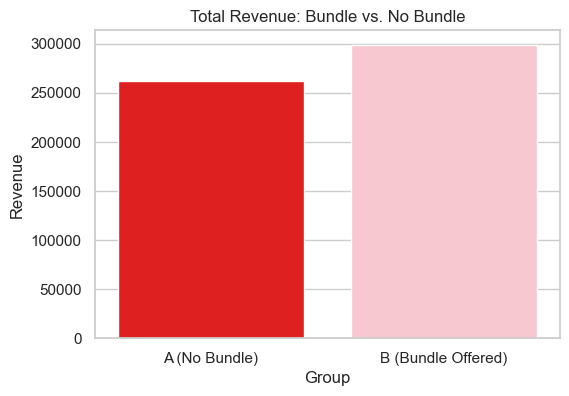

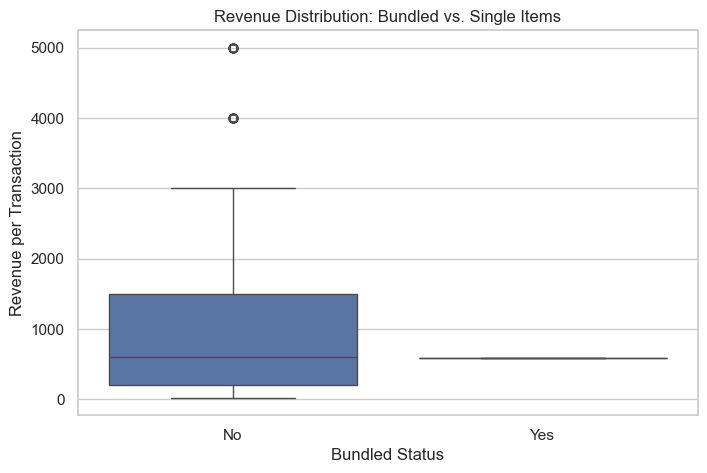

In [168]:
import matplotlib.pyplot as plt

# Revenue comparison
plt.figure(figsize=(6, 4))
sns.barplot(x='Group', y='Total Amount', data=revenue, hue = 'Group', palette=['red', 'pink'])
plt.title('Total Revenue: Bundle vs. No Bundle')
plt.ylabel('Revenue')
plt.show()

data["Bundled"] = np.where(
    data["Product Category"] == "Bundle",
    "Yes",
    "No")
    
# Boxplot of revenue per transaction (including both bundled and single items)
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="Bundled",
    y="Total Amount",
    data=data  
)
plt.title("Revenue Distribution: Bundled vs. Single Items")
plt.ylabel("Revenue per Transaction")
plt.xlabel("Bundled Status")
plt.show()

### __Price Elasticity & Revenue Optimization__
### __Visualization: Revenue vs. Price Curves__

Sports:
  Current Price: 200.00
  Optimal Price: 399.90
----------------------------------------


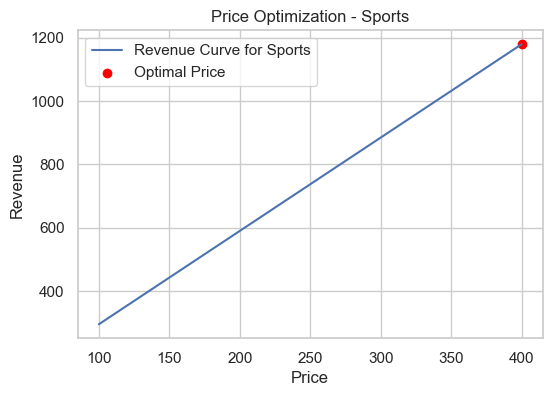

Beauty:
  Current Price: 50.00
  Optimal Price: 99.90
----------------------------------------


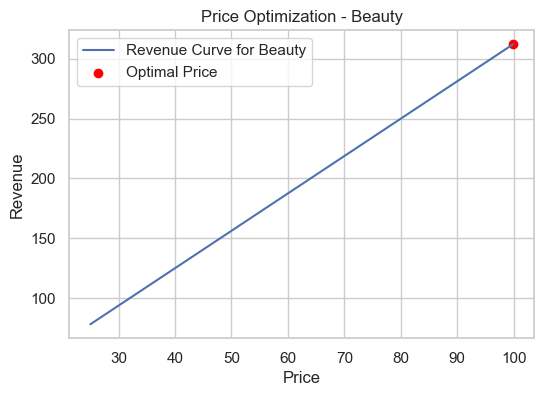

Clothing:
  Current Price: 500.00
  Optimal Price: 999.90
----------------------------------------


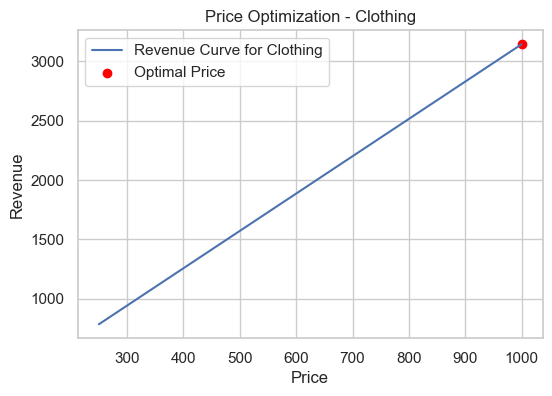

Electronics:
  Current Price: 1000.00
  Optimal Price: 1999.90
----------------------------------------


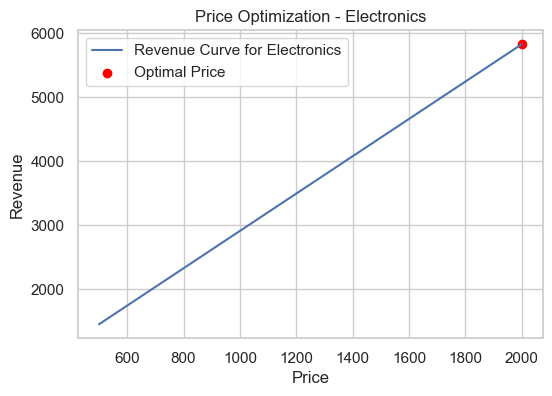

Home:
  Current Price: 300.00
  Optimal Price: 599.90
----------------------------------------


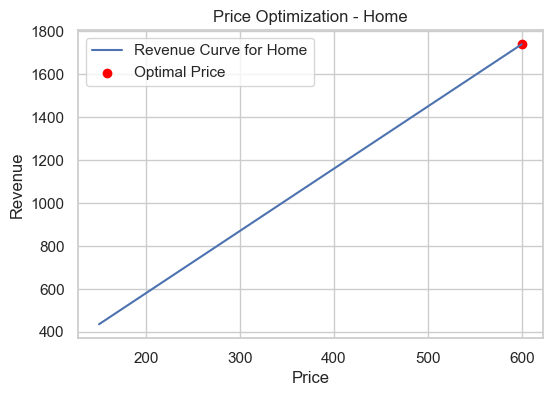

Books:
  Current Price: 20.00
  Optimal Price: 39.90
----------------------------------------


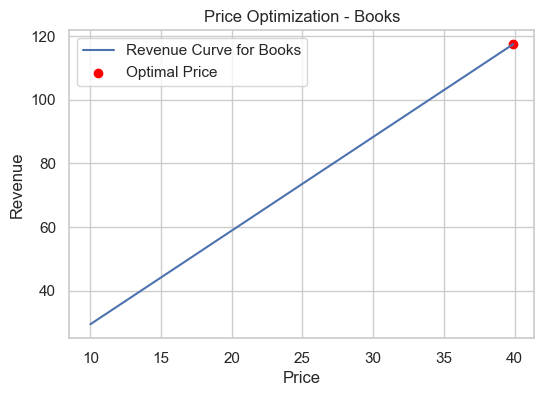

In [169]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Define key categories (example: Beauty, Sports, Home)
categories = ["Sports", "Beauty", "Clothing", 'Electronics', 'Home', 'Books']

def optimize_pricing(data, category, min_price=0.5, max_price=2.0, step=0.1):
    cat_df = data[data["Product Category"] == category].copy()
    if len(cat_df) < 5:
        print(f"Insufficient data for {category} (n < 5)")
        return None, None

    avg_price = cat_df["Price per Unit"].mean()
    avg_quantity = cat_df["Quantity"].mean()

    X = cat_df[["Price per Unit"]]
    y = cat_df["Quantity"]
    model = LinearRegression()
    model.fit(X, y)
    elasticity = model.coef_[0] * (avg_price / avg_quantity)
    if elasticity > 0:
        elasticity *= -1  # Enforce economic logic

    prices = np.arange(avg_price * min_price, avg_price * max_price, step)
    quantities = avg_quantity * (prices / avg_price) ** elasticity
    quantities = np.maximum(quantities, 0)
    revenues = prices * quantities

    optimal_idx = np.argmax(revenues)
    optimal_price = prices[optimal_idx]

    return optimal_price, (prices, revenues)


    # Calculate avg price and avg quantity before elasticity calculation
    avg_price = cat_df["Price per Unit"].mean()
    avg_quantity = cat_df["Quantity"].mean()

    # Calculate price elasticity (using linear regression as a proxy)
    X = cat_df[["Price per Unit"]]
    y = cat_df["Quantity"]
    model = LinearRegression()
    model.fit(X, y)
    elasticity = model.coef_[0] * (avg_price / avg_quantity)  # Elasticity formula

    # Simulate revenue at different prices
    prices = np.arange(avg_price * min_price, avg_price * max_price, step)
    quantities = avg_quantity * (prices / avg_price) ** elasticity
    revenues = prices * quantities

    # Find optimal price (max revenue)
    optimal_idx = np.argmax(revenues)
    optimal_price = prices[optimal_idx]

    return optimal_price, (prices, revenues)

# Generate results for all categories
results = {}
for category in categories:
    optimal_price, revenue_curve = optimize_pricing(data, category)
    if optimal_price:
        results[category] = {
            "Current Price": data[data["Product Category"] == category]["Price per Unit"].mean(),
            "Optimal Price": optimal_price,
            "Revenue Curve": revenue_curve
        }

# Print results
for category, data in results.items():
    print(f"{category}:")
    print(f"  Current Price: {data['Current Price']:.2f}")
    print(f"  Optimal Price: {data['Optimal Price']:.2f}")
    print("-" * 40)

    # Plot revenue curve for each category
    plt.figure(figsize=(6, 4))
    plt.plot(data["Revenue Curve"][0], data["Revenue Curve"][1], label=f"Revenue Curve for {category}")
    plt.scatter(data["Optimal Price"], max(data["Revenue Curve"][1]), color='red', label="Optimal Price")
    plt.title(f"Price Optimization - {category}")
    plt.xlabel("Price")
    plt.ylabel("Revenue")
    plt.legend()
    plt.grid(True)
    plt.show()


### __Customer Segmentation__
__Identify price sensitivity by age/gender:__

In [105]:
import pandas as pd

def segment_price_sensitivity(data):
    results = {}
    categories = ["Sports", "Beauty", "Clothing", "Electronics", "Home", "Books"]

    for category in categories:
        cat_df = data[data["Product Category"] == category].copy()

        if cat_df.empty:
            continue

        if cat_df["Age"].isnull().any() or cat_df["Gender"].isnull().any():
            print(f"Warning: Missing data in 'Age' or 'Gender' for {category}.")

        # Age segmentation
        cat_df.loc[:, "Age Group"] = pd.cut(
            cat_df["Age"],
            bins=[0, 30, 50, 100],
            labels=["<30", "30-50", ">50"],
            right=False
        )

        age_revenue = cat_df.groupby("Age Group", observed = True)["Total Amount"].mean().round(2)
        gender_revenue = cat_df.groupby("Gender", observed = True)["Total Amount"].mean().round(2)

        results[category] = {
            "Age Group Revenue": age_revenue,
            "Gender Revenue": gender_revenue
        }

    return results

    
# Get segmented revenue for all categories
segmented_revenue = segment_price_sensitivity(data)

# Print results for each category
for category, rev_data in segmented_revenue.items():
    print(f"\n{category} - Revenue by Age Group:")
    print(rev_data["Age Group Revenue"])
    print(f"\n{category} - Revenue by Gender:")
    print(rev_data["Gender Revenue"])
    print('-'*40)


Sports - Revenue by Age Group:
Age Group
<30      586.96
30-50    575.34
>50      603.28
Name: Total Amount, dtype: float64

Sports - Revenue by Gender:
Gender
Female    559.49
Male      609.90
Name: Total Amount, dtype: float64
----------------------------------------

Beauty - Revenue by Age Group:
Age Group
<30      142.86
30-50    159.17
>50      157.69
Name: Total Amount, dtype: float64

Beauty - Revenue by Gender:
Gender
Female    152.82
Male      159.68
Name: Total Amount, dtype: float64
----------------------------------------

Clothing - Revenue by Age Group:
Age Group
<30      1635.14
30-50    1583.33
>50      1518.18
Name: Total Amount, dtype: float64

Clothing - Revenue by Gender:
Gender
Female    1617.02
Male      1514.29
Name: Total Amount, dtype: float64
----------------------------------------

Electronics - Revenue by Age Group:
Age Group
<30      3375.00
30-50    2813.95
>50      2724.14
Name: Total Amount, dtype: float64

Electronics - Revenue by Gender:
Gender
Fema

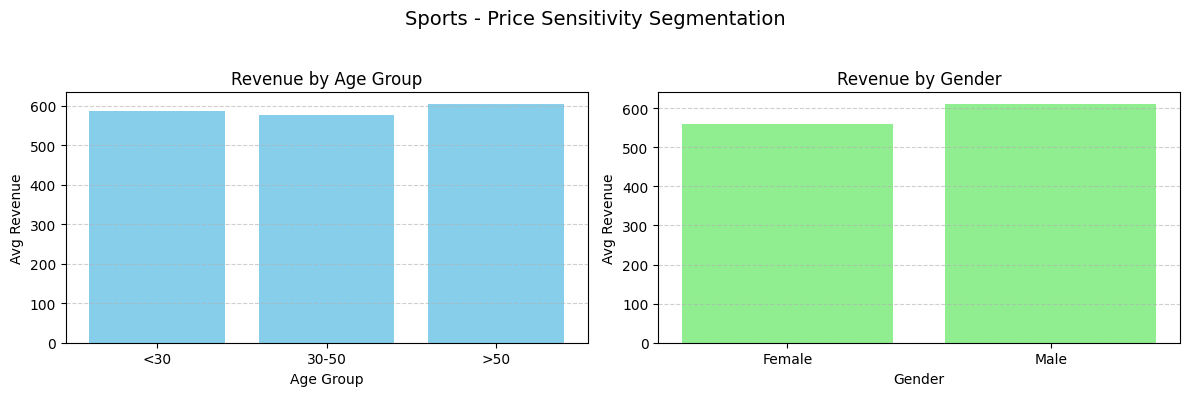

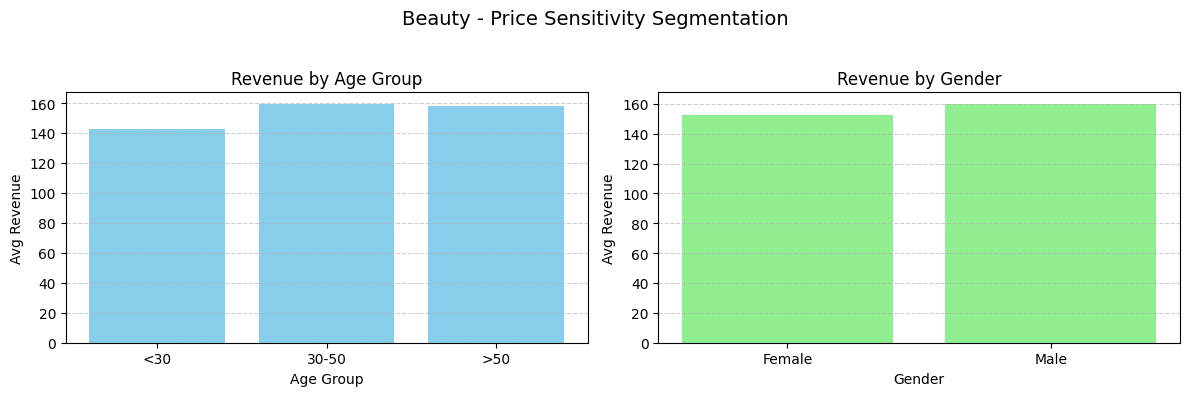

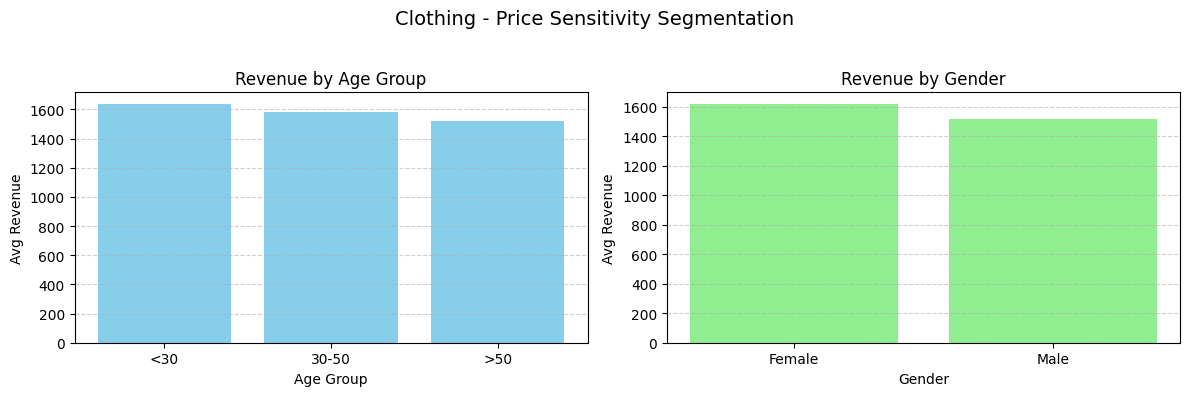

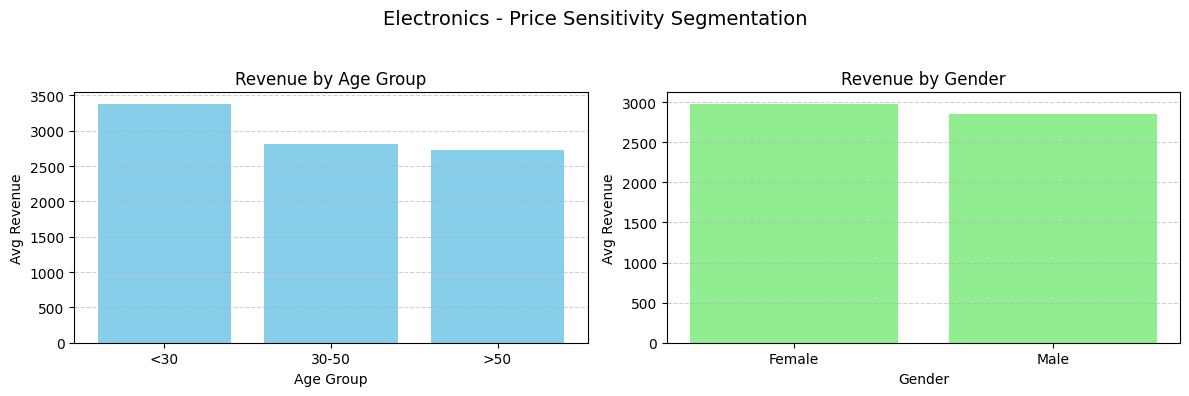

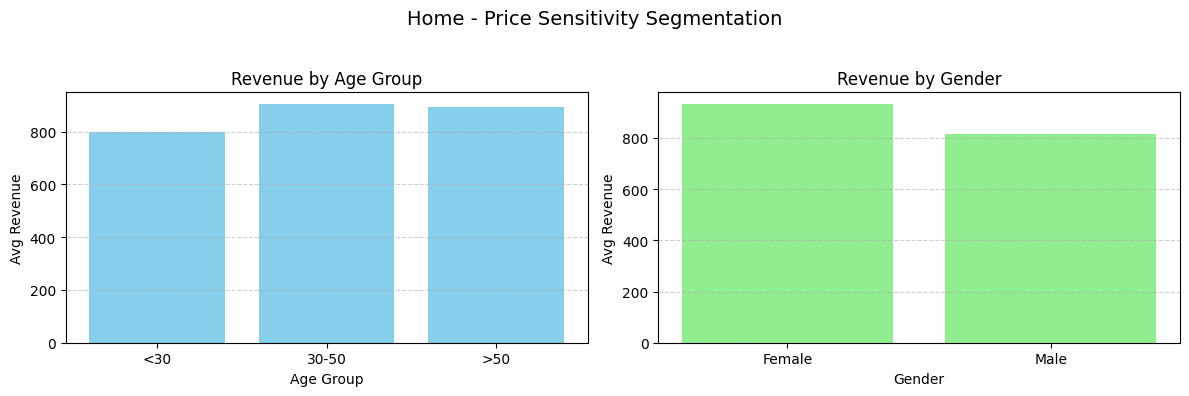

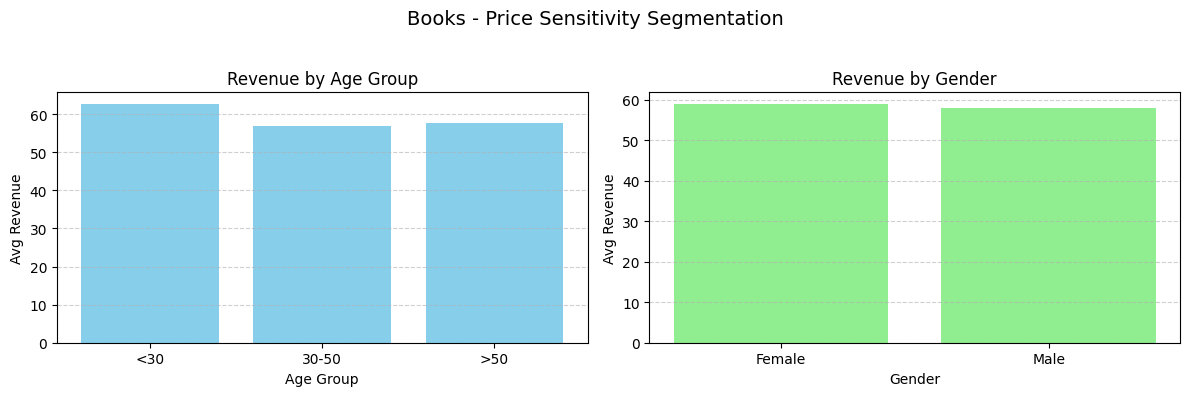

In [103]:
import matplotlib.pyplot as plt

# Visualize segmented revenue
def plot_segmented_revenue(segmented_revenue):
    for category, rev_data in segmented_revenue.items():
        age_data = rev_data["Age Group Revenue"]
        gender_data = rev_data["Gender Revenue"]

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"{category} - Price Sensitivity Segmentation", fontsize=14)

        # Bar plot for Age Group
        axes[0].bar(age_data.index.astype(str), age_data.values, color='skyblue')
        axes[0].set_title("Revenue by Age Group")
        axes[0].set_ylabel("Avg Revenue")
        axes[0].set_xlabel("Age Group")
        axes[0].grid(True, axis='y', linestyle='--', alpha=0.6)

        # Bar plot for Gender
        axes[1].bar(gender_data.index.astype(str), gender_data.values, color='lightgreen')
        axes[1].set_title("Revenue by Gender")
        axes[1].set_ylabel("Avg Revenue")
        axes[1].set_xlabel("Gender")
        axes[1].grid(True, axis='y', linestyle='--', alpha=0.6)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Call the function to display the charts
plot_segmented_revenue(segmented_revenue)
